# Plan-and-Execute

## Plan-and-Execute là gì?

Plan-and-Execute (Lập kế hoạch và Thực thi) là cách tiếp cận được đề xuất trong bài báo **"Plan-and-Solve Prompting: Improving Zero-Shot Chain-of-Thought Reasoning"**. Cách này khắc phục các hạn chế của **Zero-shot Chain-of-Thought (Zero-shot-CoT)** – tức là bắt model “suy nghĩ từng bước” mà không cần ví dụ mẫu.

---

## Hạn chế của Zero-shot-CoT (vì sao cần Plan-and-Solve?)

Khi chỉ bảo model “hãy suy nghĩ từng bước”, model thường mắc phải ba loại lỗi sau:

1. **Lỗi tính toán (Calculation Errors)**  
   Sai số trong các bước tính toán trung gian (cộng trừ nhân chia, đơn vị, v.v.).

2. **Lỗi thiếu bước (Missing-Step Errors)**  
   Bỏ qua những bước quan trọng, nhảy cóc từ giả thiết đến kết luận nên đáp án sai hoặc không đầy đủ.

3. **Lỗi hiểu ngữ nghĩa (Semantic Misunderstandings)**  
   Hiểu sai đề bài, ngữ cảnh hoặc yêu cầu (ví dụ: nhầm “tăng gấp đôi” với “tăng thêm 2”).

Plan-and-Solve ra đời để giảm các lỗi trên bằng cách **tách rõ**: trước hết **lập kế hoạch**, sau đó **thực thi từng bước**.

---

## Hai bước chính của Plan-and-Solve

### 1. Lập kế hoạch (Planning)

- Chia bài toán lớn thành **các bài con (subtasks)** rõ ràng.
- Mỗi bước được đánh số, có thứ tự, **không bỏ sót bước** cần thiết.
- Kế hoạch đóng vai trò “bản đồ” để model biết phải làm gì trước, làm gì sau.

### 2. Thực thi (Execution)

- Thực hiện **lần lượt từng bước** trong kế hoạch.
- Nếu một bước thất bại, thiếu thông tin hoặc cần hướng đi khác → **cập nhật lại kế hoạch (replan)** rồi tiếp tục thực thi.
- Nhờ vậy hệ thống vừa **linh hoạt** vừa **ổn định** khi gặp lỗi hoặc thông tin mới.

---

## Kiến trúc Plan-and-Execute (luồng hoạt động)

Trong kiến trúc Plan-and-Execute, agent hoạt động theo chu trình nhiều bước:

1. **Lập kế hoạch**: Đưa ra một chuỗi các bước (steps) để giải quyết nhiệm vụ.
2. **Thực thi từng bước**: Lần lượt thực hiện từng bước (có thể gọi công cụ, tính toán, tìm kiếm, v.v.).
3. **Đánh giá và replan (nếu cần)**:
   - Nếu một bước **thất bại** hoặc **thiếu thông tin** → agent **lập lại kế hoạch** (replan) và tiếp tục.
   - Nếu mọi bước đã xong và đủ thông tin → trả lời người dùng.

Nhờ **Planning → Execute → Replan (khi cần)**, mô hình giảm lỗi tính toán, lỗi thiếu bước và lỗi hiểu sai, đồng thời xử lý được các tình huống bất ngờ trong quá trình giải bài.


In [46]:
import operator
import os
from langgraph.graph import StateGraph, START, END
from langchain_tavily import TavilySearch
from langchain_openai import ChatOpenAI
from pydantic import BaseModel, Field
from typing import Annotated, List, Tuple, Union
from typing_extensions import TypedDict
from langchain_core.prompts import ChatPromptTemplate
from langchain.agents import create_agent
from langchain_core.tools import tool
import dotenv

import certifi
import os
import ssl
import aiohttp

# uuid
import uuid

os.environ["SSL_CERT_FILE"] = certifi.where()
os.environ["REQUESTS_CA_BUNDLE"] = certifi.where()

_orig_aiohttp_session = aiohttp.ClientSession
def _aiohttp_session_with_certifi(*args, **kwargs):
    if not args and "connector" not in kwargs:
        ssl_ctx = ssl.create_default_context(cafile=certifi.where())
        kwargs["connector"] = aiohttp.TCPConnector(ssl=ssl_ctx)
    return _orig_aiohttp_session(*args, **kwargs)
aiohttp.ClientSession = _aiohttp_session_with_certifi

# write logs to file
import logging

# uuid for log file name + plan-and-execute
log_file_name = str(uuid.uuid4()) + "_plan-and-execute"
logging.basicConfig(filename=f'logs/{log_file_name}.log', level=logging.INFO)
logger = logging.getLogger(__name__)

# write logs to file

dotenv.load_dotenv()

True

In [47]:
import asyncio

# Tránh RecursionError khi agent gọi tool async: dùng sync invoke trong thread (đã verify ở test-search)
class TavilySyncInThread(TavilySearch):
    async def ainvoke(self, input, config=None, **kwargs):
        return await asyncio.to_thread(self.invoke, input, config, **kwargs)

TOOLS = [
    TavilySyncInThread(
        max_results=3,
        topic="general",
    )
]

MODEL_LLM = os.getenv("OPENAI_MODEL")

MAX_PLAN_ITERATIONS = 4
RECURSION_LIMIT=10

In [48]:
# planner 
class Plan(BaseModel):
    steps: List[str] = Field(description="Các bước được đánh số, theo thứ tự, không trùng.")

planner_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            f"""Với mục tiêu được đưa ra, hãy lập một kế hoạch từng bước đơn giản và không quá {MAX_PLAN_ITERATIONS} bước. \
               Kế hoạch gồm các nhiệm vụ được đánh số 1->n(n là số bước tối đa), nếu thực hiện đúng sẽ ra đáp án. Không thêm bước thừa. \
               Kết quả của bước cuối phải là đáp án cuối cùng. Mỗi bước phải có đủ thông tin cần thiết, không bỏ qua bước.""",
        ),
        ("placeholder", "{messages}"),
    ]
)

planner = planner_prompt | ChatOpenAI(model=MODEL_LLM, temperature=0).with_structured_output(Plan)


In [49]:
# Replaner
class Response(BaseModel):
    response: str = Field(description="Câu trả lời cho người dùng.")

class Act(BaseModel):
    action: Union[Response, Plan] = Field(
        description="Hành động: muốn trả lời người dùng thì dùng Response; cần thêm bước hoặc dùng tool để có đáp án thì dùng Plan."
    )

# Re-planning step
replanner_prompt = ChatPromptTemplate.from_template(
    """Với mục tiêu đã cho, hãy lập một kế hoạch từng bước đơn giản có đánh số 1->n (n là số bước tối đa).
    Kế hoạch gồm các nhiệm vụ riêng lẻ, thực hiện đúng sẽ ra đáp án. Không thêm bước thừa.
    Kết quả của bước cuối phải là đáp án cuối cùng. Mỗi bước phải có đủ thông tin, không bỏ qua.

    Mục tiêu của bạn là:
    {input}

    Kế hoạch ban đầu là:
    {plan}

    Các bước đã thực hiện và kết quả:
    {past_steps}

    Cập nhật kế hoạch cho phù hợp. Nếu kết quả một bước không đủ, thất bại hoặc gợi ý hướng khác, bạn CÓ THỂ thêm bước mới hoặc sửa bước tiếp theo (replan). Nếu không còn bước nào cần làm và có thể trả lời người dùng thì trả lời. Ngược lại, chỉ đưa vào kế hoạch những bước VẪN CẦN làm. Không đưa lại các bước đã làm vào kế hoạch."""
)

replanner = replanner_prompt | ChatOpenAI(model=MODEL_LLM, temperature=0).with_structured_output(Act)

In [50]:
# Define the Plan and Execution structure
agent_executor = create_agent(
    model=ChatOpenAI(
        model=MODEL_LLM,
        temperature=0
    ),
    tools=TOOLS,
    system_prompt="Bạn là trợ lý hữu ích. Khi cần dữ liệu mới nhất hoặc tra cứu, hãy dùng công cụ tìm kiếm."
)

class PlanExecute(TypedDict):
    input: str # plan request input
    plan: List[str] # plan steps
    past_steps: Annotated[List[Tuple], operator.add] # past steps
    response: str # response to user
    plan_iteration: Annotated[int, operator.add] # plan iteration

In [51]:
# Planning step function
async def plan_step(state: PlanExecute):
    logger.info('RUNNING plan_step')
    plan = await planner.ainvoke({"messages": [("user", state["input"])]})
    return {"plan": plan.steps}

# Execution step function
async def execute_step(state: PlanExecute):

    logger.info('RUNNING Executing step')
    # state 
    logger.info(f"Function execute_step State: {state}")
    plan = state["plan"]
    plan_iteration = state["plan_iteration"]


    # log plan
    logger.info(f"Function execute_step Plan: {plan}")
   
    plan_str = "\n".join(f"{i+1}. {step}" for i, step in enumerate[str](plan))

    # log plan_str
    logger.info(f"Function execute_step Plan_str: {plan_str}")

    task = plan[0]

    # log task
    logger.info(f"Function execute_step Task: {task}")

    task_formatted = f"Kế hoạch hiện tại:\n{plan_str}\n\nBạn đang thực hiện bước {plan_iteration}: {task}."

    # log task_formatted
    logger.info(f"Function execute_step Task_formatted: {task_formatted}")
    agent_response = await agent_executor.ainvoke({"messages": [("user", task_formatted)]})

    # log agent_response
    logger.info(f"Function execute_step Agent_response: {agent_response}")

    # log past_steps
    logger.info(f"Function execute_step Past_steps: {[(task, agent_response['messages'][-1].content)]}")

    return {
        "past_steps": [(task, agent_response["messages"][-1].content)],
        "plan_iteration": 1,  # để replan_step có thể dừng sau MAX_PLAN_ITERATIONS
    }

# Re-planning step function
async def replan_step(state: PlanExecute):
    # Tránh loop: nếu đã chạy quá nhiều vòng thì ép trả response và dừng
    iterations = state.get("plan_iteration", 0)
    logger.info(f"Function replan_step Iterations: {iterations}")
    if iterations >= MAX_PLAN_ITERATIONS:
        summary = "\n".join(f"- {step}: {result}" for step, result in (state.get("past_steps") or []))
        return {"response": f"Đã đạt tối đa {MAX_PLAN_ITERATIONS} bước. Kết quả hiện tại:\n{summary or 'Chưa có.'}"}

    output = await replanner.ainvoke(state)

    if isinstance(output.action, Response):
        logger.info(f"Function replan_step Output.action: {output.action}")
        return {"response": output.action.response}
    # Nếu replanner trả plan rỗng → coi như đã xong, trả response từ bước cuối
    if not getattr(output.action, "steps", None):
        last = (state.get("past_steps") or [])[-1]
        logger.info(f"Function replan_step Last: {last}")
        return {"response": last[1] if last else "Hoàn thành."}
        
    logger.info(f"Function replan_step Output.action.steps: {output.action.steps}")
    return {"plan": output.action.steps}

# Conditional check for ending (quay lại execute_step khi chưa có response)
def should_end(state: PlanExecute):
    if state.get("response"):
        return END
    return "execute_step"  # tiếp tục thực hiện bước tiếp theo trong plan

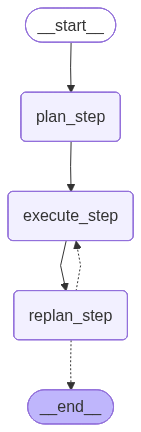

In [52]:
# Build the workflow
workflow = StateGraph(PlanExecute)

# Add nodes to the workflow
workflow.add_node("plan_step", plan_step)
workflow.add_node("execute_step", execute_step)
workflow.add_node("replan_step", replan_step)

# Add edges to transition between nodes
workflow.add_edge(START, "plan_step")

workflow.add_edge("plan_step", "execute_step")
workflow.add_edge("execute_step", "replan_step")
workflow.add_conditional_edges("replan_step", should_end, ["execute_step", END])

# Compile the workflow into an executable application
app = workflow.compile()

# Visualization of the workflow
app

In [53]:
from pprint import pprint  # thư viện có sẵn, in dict/list cho dễ đọc

async def run_plan_and_execute():
    user_input = {
        "input": "Tìm dân số Việt Nam 2024 và 2023, tính mức tăng. Nếu không có số liệu 2024 thì dùng năm gần nhất."
    }

    async for event in app.astream(
        input=user_input,
        config={
            "recursion_limit": RECURSION_LIMIT
        }
    ):
        for k, v in event.items():
            if k != "__end__":
                pprint(v)

await run_plan_and_execute()

{'plan': ['Tìm kiếm thông tin về dân số Việt Nam năm 2023. Dân số Việt Nam năm '
          '2023 ước tính khoảng 99 triệu người.',
          'Tìm kiếm thông tin về dân số Việt Nam năm 2024. Nếu không có số '
          'liệu chính thức, sử dụng số liệu năm 2023 làm cơ sở.',
          'Tính mức tăng dân số bằng cách lấy dân số năm 2024 (hoặc 2023) trừ '
          'đi dân số năm 2023 và chia cho dân số năm 2023, sau đó nhân với 100 '
          'để có tỷ lệ phần trăm.',
          'Kết luận mức tăng dân số Việt Nam từ năm 2023 đến năm 2024.']}
{'past_steps': [('Tìm kiếm thông tin về dân số Việt Nam năm 2023. Dân số Việt '
                 'Nam năm 2023 ước tính khoảng 99 triệu người.',
                 'Dân số Việt Nam năm 2023 ước tính khoảng 100 triệu người, '
                 'theo thông tin từ UNFPA. Cụ thể, dân số Việt Nam đã đạt mốc '
                 '100 triệu vào năm 2023, trở thành quốc gia đông dân thứ 15 '
                 'trên thế giới. \n'
                 '\n'
              